# 3.6 Predicting House Prices: A Regression Example

_In regression, it's simple if you think that you're trying to predict a continuous value rather than a class or label as in classification._

## 3.6.1 The Boston Housing Price Dataset

The differences in this dataset compared to the previous two is that,

1. The size is relatively small (506 - 404 training and 102 test).

2. All of the features have different scales.

In [1]:
from keras.datasets import boston_housing


(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print("train_data.shape = {}".format(train_data.shape))
print("test_data.shape = {}".format(test_data.shape))

Using TensorFlow backend.


57344/57026 [==============================] - 0s 7us/step
train_data.shape = (404, 13)
test_data.shape = (102, 13)


## 3.6.2 Preparing the Data

Remember that we want to normalize our features. The neural network will probably be able to adjust on its own, but we want to make that process easier.

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 3.6.3 Building  Your Network

_We'll be using a smaller network (two hidden layers) because we have few data. The fewer data you have,  the worse overfitting will be._

In [3]:
from keras import models, layers


def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

## 3.6.4 Validating Your Approach Using $K$-Fold Validation

In [4]:
import numpy as np


k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores =[]

for i in range(k):
    print("Processing fold {}".format(i))
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    all_scores.append(val_mae)

Processing fold 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Processing fold 1
Processing fold 2
Processing fold 3


In [5]:
all_scores

[2.0457939476069837, 2.1715325577424305, 2.95846685796681, 2.390411168041796]

In [7]:
np.mean(all_scores)

2.391551132839505

In [8]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("Processing fold {}".format(i))
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    
    all_mae_histories.append(mae_history)

Processing fodl 0
Processing fodl 1
Processing fodl 2
Processing fodl 3


In [9]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

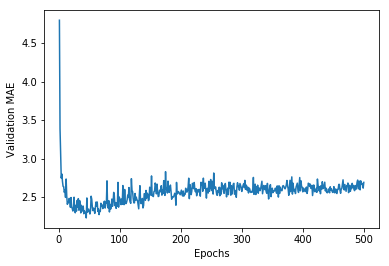

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

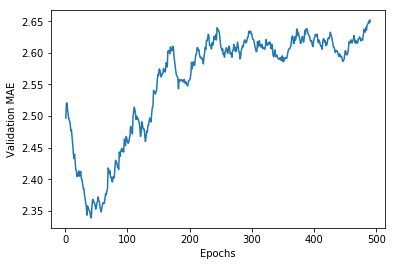

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    
    for point in points:
        if (smoothed_points):
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

In [13]:
model = build_model()

model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 860us/step


In [14]:
test_mae_score

2.673004758124258

## 3.6.5 Wrapping Up

1. Regression and classification have different loss functions. Mean squared error (MSE) is commonly used in regression problems.

2. Loss functions and evaluation functions are different. In this case, we're using the mean absolute error (MAE). If you think about it this makes sense because it doesn't make sense to evaluate a regression problem using "accuracy."

3. It's good to scale your features so that they're in the same range.

4. When you have little data available using $K$-fold evaluation is a good idea.

5. When little training data is available using a smaller network is usually a better idea.